# Landing the Lunar Lander Like an Airplane with CMA-ME

Within the [OpenAI Gym](https://gym.openai.com) toolkit, the [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) is a task where an agent must control a spaceship to touch down gently within a goal zone near the bottom of the screen. Typically, agents in Lunar Lander take a direct approach, gently gliding straight down like this:

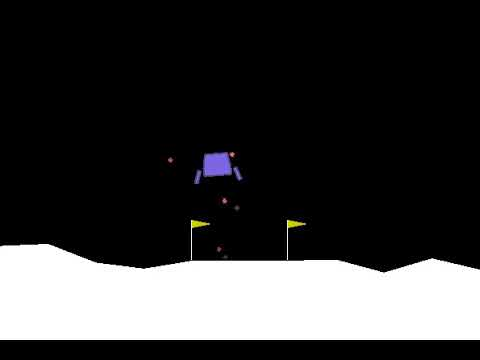

In [1]:
# Credits to Ronny Restrepo
# TODO: put up our own video
from IPython.display import YouTubeVideo
YouTubeVideo('x6lw5GsJvjQ', width=560, height=315)

An approach like this nets an excellent reward (TODO), but Lunar Lander is already considered solved after a reward of 200. Are there any other ways to land a Lunar Lander that are less obvious and, frankly, more exciting? Of course 😉. For instance, we can land it like an airplane:

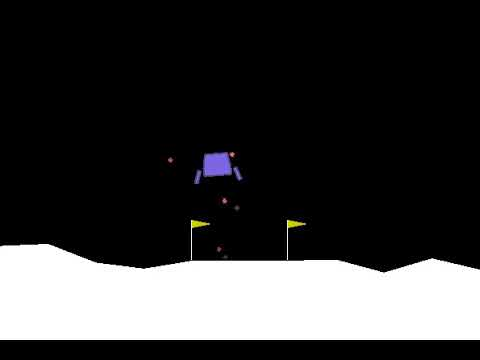

In [2]:
# TODO
YouTubeVideo('x6lw5GsJvjQ', width=560, height=315)

This trajectory gets (TODO) reward, meaning it still solves the task. In this tutorial, we will create trajectories like this and many others. To do so, we will use the pyribs implementation of CMA-ME.

## Setup

First, we shall retrieve dependencies. We freeze our versions in order to make results reproducible. If this command updates or installs any dependencies, you may need to restart the kernel to make sure they are used.

In [3]:
%pip install ribs[all] gym~=0.17.0 Box2D~=2.3.10 tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import time

import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # TODO: use GridArchiveHeatmap
from IPython.display import display, HTML
from tqdm.notebook import tqdm

from ribs.archives import GridArchive
from ribs.emitters import ImprovementEmitter
from ribs.optimizers import Optimizer

## Lunar Lander Simulation

TODO

First, let's write a `simulate()` function to run a prospective solution in the `LunarLander-v2` environment. We'll get to how we generate these prospective solutions later.

`simulate()` takes in a prospective solution (i.e. policy) and uses this policy to make the Lunar Lander take actions in the environment. After the simulation is completed, `simulate()` returns several things. It returns the sum of the rewards of all actions taken in the environment (i.e. `total_reward`), the final state of the environment (i.e. `obs`), and the number of timesteps it took for the simulation to run to completion (i.e. `timesteps`).

In [5]:
def simulate(env, model, seed=None):
    """Simulates the lunar lander model and returns objective and BCs.

    Args:
        env (gym.Env):
        model (np.ndarray):
        seed (int):
    Returns:
        objective (float):
        impact_x_pos (float):
        impact_y_vel (float):
    """
    # Seeding the environment ensures simulations are deterministic.
    if seed is not None:
        env.seed(seed)

    action_dim = env.action_space.n
    obs_dim = env.observation_space.shape[0]
    model = model.reshape((action_dim, obs_dim))

    objective = 0.0
    timesteps = 0
    obs = env.reset()
    impact_x_pos = None
    impact_y_vel = None
    done = False

    while not done:
        action = np.argmax(model @ obs)  # Linear policy.
        obs, reward, done, info = env.step(action)
        objective += reward

        # Refer to the definition of state here:
        # https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py#L306
        x_pos = obs[0]
        y_vel = obs[3]
        leg0_touch = bool(obs[6])
        leg1_touch = bool(obs[7])

        # Check if the lunar lander is impacting for the first time.
        if impact_x_pos is None and (leg0_touch or leg1_touch):
            impact_x_pos = x_pos
            impact_y_vel = y_vel

    # If the lunar lander did not land, set the y-vel and x-pos to the ones
    # from the final timestep.
    if impact_x_pos is None:
        impact_x_pos = x_pos
        impact_y_vel = y_vel

    return objective, impact_x_pos, impact_y_vel

## MAP-Elites with `ribs`

`ribs` makes it easy to run the MAP-Elites algorithm to solve reinforcement learning problems. Let's run through  some basics before we apply `ribs` to solve the Lunar Lander problem.

### GridArchive

`GridArchive` is a container class used to house the solutions generated by MAP-Elites. It is our map of elites. When constructing a `GridArchive`, you can specify its dimensions, the range of valid values in our behaviour space, and certain configuration settings. These configuration settings include a seed for getting random solutions in the archive to mutate, which is essential to MAP-Elites, and a batch size. This batch size is not important for `GridArchive` but it is important for `Optimizer`, which we'll discuss soon.

In `train_model()`, you see we create an `archive = GridArchive((16, 16), [(0, 1000), (-1., 1.)], config=config)`. Let's break this down.

- `(16, 16)` specifies that we are creating a 2D 16x16 container for solutions. 16x16 was chosen arbitrarily.

- `[(0, 1000), (-1., 1.)]` specifies upper and lower bounds for each dimension of the behavior space. In the case of Lunar Lander, we want to consider timesteps and x-position of the Lunar Lander in the environment. According to OpenAI Gym documention, each simulation can take at least 0 timesteps and at most 1000 timesteps, so we specify `(0, 1000)`. Looking at `LunarLander-v2`'s source code, we find that the minimum x-position value for the lander is -1.0 and the maximum value is 1.0, so we specify `(-1., 1.)`.
- `config` is a dictionary that specifies certain configuration settings. As stated previously, the only value that `GridArchive` uses is the seed. `config` will also later be passed into `Optimizer`, which we'll discuss soon.

`GridArchive` has a method `as_pandas()` that returns the `GridArchive` as a `pandas` data frame.

### GaussianEmitter
`GaussianEmitter` is the class that generates solutions to either store in `GridArchive` or discard. As the name implies, it uses a Gaussian distribution to generate/mutate solutions. 

In `train_model()`, we create `emitter = GaussianEmitter(np.zeros(action_dim * obs_dim), sigma, archive)`. Let's break this down by looking at `GaussianEmitter`'s constructor: `GaussianEmitter(x0, sigma0, archive, config=None)`

- `x0` is the center of the Gaussian distribution to generate solutions from when the archive specified by `archive` is empty of solutions. 
- `sigma0` is the standard deviation of the Gaussian distribution. Here, we simply pass in the sigma value passed into `train_model()`.
- `archive` specifies the archive to store solutions in. In this case, we pass in the `GridArchive` we created earlier.
- `config` allows you to pass in configuration settings, including specifications for batch sizes. Here, we don't pass anything in because `GaussianEmitter`'s default batch size is 64, which works for us.

`GaussianEmitter` has two functions. `ask()` generates a batch of new solutions, either a completely new solution sampled from a Gaussian distribution or a solution generated by mutating (i.e. adding Gaussian noise) an existing solution. `tell()` takes in a batch of solutions, along with their performance values and behavior characteristics, and adds them to the archive specified by `archive` by calling `archive.add()`. `archive.add()` will decide whether or not to store each new solution by comparing each new solution's objective value with their corresponding existing solution's objective value. If for a given new solution there is no corresponding existing solution, then the new solution is automatically stored. `Optimizer`, which we discuss next, takes care of calling `ask()` and `tell()` for you, so you don't need to worry about these details.

### Optimizer

`Optimizer` is a class that uses emitters to generate batches of solutions. Then, after the feature/behavior description of each of these solutions have been found, `Optimizer` tells its emitters to store the solutions inside an archive.

In `train_model()`, you see that we create `opt = Optimizer(archive, [emitter])`. This is pretty self-explanatory. `archive` is the archive we want our solutions to be stored in. In this case, we created earlier in `train_model()`. We also want to pass in a list of `Emitter`'s we want the `Optimizer` to ask to generate solutions. In our case, we pass in `[emitter]`, which is a list of `Emitter`s just containing the emitter we created earlier in `train_model()`. 

`Optimizer` has two methods `ask()` and `tell()`. `ask()` asks the `Optimizer`'s list of `Emitter`s to generate a batch of solutions. `tell()` tells the `Optimizer`'s list of `Emitter`s to store a batch of solutions in the archive specified upon the `Optimizer`'s creation. However, in order for the `Emitter`s to know where and if to store each solution in the archive, we have to pass in a couple of additional arguments into `tell()`. 

Specifically, `tell()` has the following arguments: `def tell(objective_values, behavior_values)`

- `objective_values` is an array containing the objective function evaluations for each solution generated by the `Emitter`s we passed into this `Optimizer`. In `train_model()`, you can see we pass in `objs` for this argument. `objs` is a list of reward values derived by running the `simulate()` function described above on each individual solution.
- `behavior_values` is a matrix of feature descriptions for each solution. Each row of `behavior_values` describes features of one solution, and these features are used as coordinates to store each solution into an archive. In `train_model()`, we pass in `bcs` as our `behavior_values` argument. The significance of `bcs` was discussed in an earlier section. Check above if you've forgotten.



###  `train_model()`

We've just gone over the core components of ribs that we'll be using to solve `LunarLander-v2`: `GridArchive`, `Gaussian_Emitter`, and `Optimizer`. Now, take a look at `train_model()` for how exactly we solve the problem.

In [6]:
env = gym.make("LunarLander-v2")
seed = 9
action_dim = env.action_space.n
obs_dim = env.observation_space.shape[0]
initial_model = np.zeros((action_dim, obs_dim))

archive = GridArchive([50, 50], [(-1.0, 1.0), (-3.0, 0.0)])
emitters = [ImprovementEmitter(
    archive,
    initial_model.flatten(),
    1.0,
)]
optimizer = Optimizer(archive, emitters)

In [7]:
print(emitters[0].batch_size)

14


In [8]:
start_time = time.time()
total_itrs = 3000
for itr in tqdm(range(1, total_itrs + 1)):
    sols = optimizer.ask()
    objs, bcs = [], []
    for model in sols:
        obj, impact_x_pos, impact_y_vel = simulate(env, model, seed)
        objs.append(obj)
        bcs.append([impact_x_pos, impact_y_vel])
    optimizer.tell(objs, bcs)
    
    if itr % 50 == 0:
        df = archive.as_pandas(include_solutions=False)
        elapsed_time = time.time() - start_time
        print(f"> {itr} itrs completed after {elapsed_time} s")
        print(f"  - Archive Size: {len(df)}")
        print(f"  - QD Score: {df['objective'].sum()}")
        print(f"  - Max Score: {df['objective'].max()}")

> 50 itrs completed after 27.295958042144775 s
  - Archive Size: 419
  - QD Score: -70179.59770125906
  - Max Score: 157.48248673761503
> 100 itrs completed after 67.22021579742432 s
  - Archive Size: 682
  - QD Score: -104858.29941716642
  - Max Score: 247.32204886461244
> 150 itrs completed after 169.54919528961182 s
  - Archive Size: 911
  - QD Score: -125852.59571534388
  - Max Score: 247.32204886461244
> 200 itrs completed after 273.4124505519867 s
  - Archive Size: 1006
  - QD Score: -115183.1483561022
  - Max Score: 268.1895758503091
> 250 itrs completed after 292.679616689682 s
  - Archive Size: 1026
  - QD Score: -107367.30228757129
  - Max Score: 268.1895758503091
> 300 itrs completed after 332.821750164032 s
  - Archive Size: 1175
  - QD Score: -121922.94928831153
  - Max Score: 268.1895758503091
> 350 itrs completed after 370.8049178123474 s
  - Archive Size: 1311
  - QD Score: -131868.9711524942
  - Max Score: 268.1895758503091
> 400 itrs completed after 404.2994785308838 

<AxesSubplot:xlabel='index_0', ylabel='index_1'>

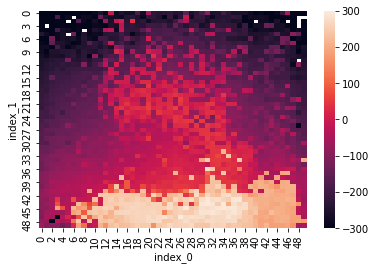

In [9]:
# TODO: Replace with pyribs heatmap
df = archive.as_pandas(include_solutions=False)
heatmap_data = df.pivot('index_1', 'index_0', 'objective')
sns.heatmap(heatmap_data, vmin=-300, vmax=300)

## Visualization

In [10]:
df[df["objective"] > 200]

,index_0,index_1,behavior_0,behavior_1,objective
0,31,48,0.253531,-0.110757,272.197184
4,22,44,-0.100350,-0.327493,261.130286
5,34,46,0.386860,-0.208187,272.969818
9,38,48,0.529308,-0.103245,243.050168
11,39,49,0.564281,0.003036,230.681011
...,...,...,...,...,...
2368,24,48,-0.022046,-0.076830,242.265544
2369,13,42,-0.442756,-0.479610,243.686927
2374,10,45,-0.591597,-0.241811,248.508143
2388,6,45,-0.743685,-0.264944,219.343818


In [15]:
import base64
import glob
import io

video_env = gym.wrappers.Monitor(
    gym.make("LunarLander-v2"),
    "videos",
    force=True,  # Overwrite existing videos.
    video_callable=lambda idx: True,  # Make all episodes be recorded.
)

sol, obj, beh = archive.elite_with_behavior([-0.44, -0.48])
print(obj)
print(beh)
simulate(video_env, sol, seed)

# Save videos.
video_env.close()

244.09686647939253
[-0.40657932 -0.42063645]


In [14]:
for video_file in glob.iglob("videos/*.mp4"):
    print(video_file)
    video = io.open(video_file, 'rb').read()
    encoded = base64.b64encode(video).decode("ascii")
    display(HTML(f'''
        <video width="360" height="auto" alt="test" controls>
            <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
        </video>
    '''))

videos/openaigym.video.1.165768.video000000.mp4


## Credits

This tutorial is based on a [poster](https://1l7puj10vwe3zflo2jsktkit-wpengine.netdna-ssl.com/wp-content/uploads/2020/08/S20-Klapsis-Poster.pdf) created by Nikitas Klapsis as part of USC's 2020 SHINE program.